In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from RunningEnv import RunningEnv
from RunningEnv import EnvWrapper
from RunningEnv import EwmaBiasState
from TransitionBatch import TransitionBatch
import torch as th
import numbers

In [2]:
pref_pace = 181
target_pace = pref_pace*1.1

In [3]:
#Make environment
env = EnvWrapper(pref_pace, target_pace)

In [4]:
class HeuristicAgent:
    def __init__(self):
        self.initial_wait = 20
        self.initial_completed = False

    def select_action(self, state):
        avg_pace = state[0]
        action = 0

        # Initial waiting time
        if not(self.initial_completed):
            self.initial_wait = self.initial_wait - 1
            if self.initial_wait == 0:
                self.initial_completed = True

        if abs(avg_pace) > 27e-3:
            action = 4

        elif abs(avg_pace) > 22e-3:
            action = 3

        elif abs(avg_pace) > 15e-3:
            action = 2

        elif abs(avg_pace) > 11e-3:
            action = 1

        return action

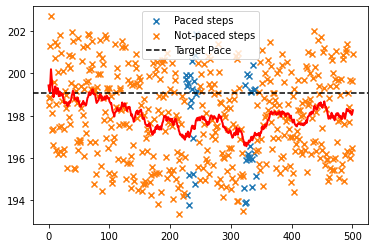

6590.0


In [12]:
heuristic_agent = HeuristicAgent()

state = env.reset()
done = 0

while not done:
    action = heuristic_agent.select_action(state)
    new_state, reward, done = env.step(action)
    # if action != 0:
    #     print(action, state, new_state, reward)
    state = new_state

x = np.linspace(0, len(env.env_pacing), len(env.env_pacing))
plt.scatter(x[np.array(env.env_pacing)==1], np.array(env.pace)[np.array(env.env_pacing)==1], marker="x", label='Paced steps')
plt.scatter(x[np.array(env.env_pacing)==0], np.array(env.pace)[np.array(env.env_pacing)==0], marker="x", label='Not-paced steps')

plt.axhline(y=target_pace, color='k', linestyle='--', label='Target Pace')

plt.plot(x, env.state_traj, 'r-', linewidth=2)
plt.legend()
plt.show()

print(np.sum(env.rewards))

In [4]:
results =np.zeros((40,10))
tests = ['CP103', 'IP103', 'CP110', 'IP110']
test_name = ['Continuous 3%', 'Intermittent 3%', 'Continuous 10%', 'Intermittent 10%']
for j in range(0,10):
    transitions = 0
    for participant in range(1, 10, 1): #16
        participant_number = str(participant)

        for i in range(len(tests)):
            # print("Runner %s - %s" % (participant_number, test_name[i]))
            calculated_values = pd.read_csv(data_folder_path + ('calculated_variables/%s_R_%s_calculated.csv')%(tests[i], participant_number))

            target_pace = calculated_values[calculated_values['pacing_frequency'].notna()]['pacing_frequency'].mean()
            calculated_values_norm = calculated_values.copy()
            calculated_values_norm['norm_step_frequency'] = calculated_values_norm['step_frequency']/target_pace

            env = RunningEnv(target_pace)
            wrapper = EnvWrapper(target_pace, target_pace)
            state_func = EwmaBiasState()
            timestep = 0
            state = 0
            action = 0
            reward = 0
            n_state = 0
            finish_leap = False
            skip_steps = 0
            total_reward = 0
            # Add first value
            add_zero = 1

            for row in calculated_values_norm.to_numpy():

                if skip_steps > 0:
                    if skip_steps ==1:
                        finish_leap = True
                    skip_steps -= 1
                    timestep += 1
                    continue
                else:
                    avg_pace = state_func.get_next_state(row[2])
                    n_state = (avg_pace / target_pace) - 1

                    if timestep == 0:
                        state = n_state
                        timestep += 1
                        continue

                    if finish_leap:
                        # print(timestep, state, n_state, action, reward, avg_pace, target_pace)
                        transitions += 1
                        total_reward += reward
                        # Add random small 0's
                        add_zero = np.random.randint(0,4)

                        finish_leap = False

                    if(not pd.isna(row[3]) and add_zero == 0):
                        action = np.random.randint(1,len(wrapper.times))
                        reward = - wrapper.times[action]
                        skip_steps = wrapper.times[action] + 1
                    else:
                        if add_zero > 0:
                            add_zero -= 1
                        action = 0
                        reward = env.get_distance_reward(target_pace, avg_pace)
                        # print(timestep, state, n_state, action, reward, avg_pace, target_pace)
                        transitions += 1
                        total_reward += reward

                state = n_state
                timestep += 1
            # print("Runner %s - %s R: %d" % (participant_number, test_name[i], total_reward))
    print(transitions)

4451
4404
4507
4430
4505
4301
4372
4491
4438
4482


In [5]:
stats = np.concatenate((np.mean(results, axis=-1).reshape(40,1), np.std(results, axis=-1).reshape(40,1)), axis=1)

In [6]:
state_shape = (1,)
def transition_format():
    """ Returns the format of transtions: a dictionary of (shape, dtype) entries for each key. """
    return {'actions': ((1,), th.long),
            'states': (state_shape, th.float32),
            'next_states': (state_shape, th.float32),
            'rewards': ((1,), th.float32),
            'dones': ((1,), th.bool),
            'returns': ((1,), th.float32)}

In [7]:
def _wrap_transition(s, a, r, ns, d):
    """ Takes a transition and returns a corresponding dictionary. """
    trans = {}
    form = transition_format()
    for key, val in [('states', s), ('actions', a), ('rewards', r), ('next_states', ns), ('dones', d)]:
        if not isinstance(val, th.Tensor):
            if isinstance(val, numbers.Number) or isinstance(val, bool): val = [val]
            val = th.tensor(val, dtype=form[key][1])
        if len(val.shape) < len(form[key][0]) + 1: val = val.unsqueeze(dim=0)
        trans[key] = val
    return trans

In [8]:
my_transition_buffer = TransitionBatch(4500, transition_format())
time, episode_start, episode_lengths, episode_rewards = 0, 0, [], []
max_steps = 1000

In [20]:
exp_batch = [16, 10]
t = 0
gamma = 0.99
tests = [['PNPpref', 'PNPfast'], ['CP103', 'IP103', 'CP110', 'IP110']]
test_name = [['Pref.pace', '10% faster'], ['Continuous 3%', 'Intermittent 3%', 'Continuous 10%', 'Intermittent 10%']]

for exp in range(len(exp_batch)):
    for participant in range(1, exp_batch[exp]):
        participant_number = str(participant)
        for i in range(len(tests[exp])):
            calculated_values = pd.read_csv(data_folder_path + ('calculated_variables/%s_R_%s_calculated.csv')%(tests[exp][i], participant_number))

            target_pace = calculated_values[calculated_values['pacing_frequency'].notna()]['pacing_frequency'].mean()
            calculated_values_norm = calculated_values.copy()
            calculated_values_norm['norm_step_frequency'] = calculated_values_norm['step_frequency']/target_pace

            env = RunningEnv(target_pace)
            wrapper = EnvWrapper(target_pace, target_pace)
            state_func = EwmaBiasState()
            timestep = 0
            state = 0
            action = 0
            reward = 0
            n_state = 0
            finish_leap = False
            skip_steps = 0
            total_reward = 0
            # Add first value
            add_zero = 1

            for row in calculated_values_norm.to_numpy():

                if skip_steps > 0:
                    if skip_steps ==1:
                        finish_leap = True
                    skip_steps -= 1
                    timestep += 1
                    continue
                else:
                    avg_pace = state_func.get_next_state(row[2])
                    n_state = (avg_pace / target_pace) - 1

                    if timestep == 0:
                        state = n_state
                        timestep += 1
                        continue

                    if finish_leap:
                        # print(timestep, state, n_state, action, reward, avg_pace, target_pace)
                        my_transition_buffer.add(_wrap_transition(state, action, reward, n_state, 0))
                        t+=1
                        total_reward += reward
                        # Add random small 0's
                        # add_zero = np.random.randint(0,4)

                        finish_leap = False

                    if(not pd.isna(row[3]) and add_zero == 0):
                        action = np.random.randint(1,len(wrapper.times))
                        reward = - wrapper.times[action]
                        skip_steps = wrapper.times[action] + 1
                    else:
                        if add_zero > 0:
                            add_zero -= 1
                        action = 0
                        reward = env.get_distance_reward(target_pace, avg_pace)
                        # print(timestep, state, n_state, action, reward, avg_pace, target_pace)
                        my_transition_buffer.add(_wrap_transition(state, action, reward, n_state, 0))
                        t+=1
                        total_reward += reward

                state = n_state
                timestep += 1
            # results[((participant-1)*4)+(i)][j] = total_reward
            if t > 4500:
                t=4500-1
            my_transition_buffer['returns'][t] = my_transition_buffer['rewards'][t]
            for i2 in range(t - 1, episode_start - 1, -1):
                my_transition_buffer['returns'][i2] = my_transition_buffer['rewards'][i2] \
                                                     + gamma * my_transition_buffer['returns'][i2 + 1]
            episode_start = t + 1
            print("Runner %s - %s R: %d" % (participant_number, test_name[exp][i], total_reward))

Runner 1 - Pref.pace R: -827
Runner 1 - 10% faster R: -775
Runner 2 - Pref.pace R: 64
Runner 2 - 10% faster R: -20851
Runner 3 - Pref.pace R: 3487
Runner 3 - 10% faster R: 623
Runner 4 - Pref.pace R: 3975
Runner 4 - 10% faster R: -215
Runner 5 - Pref.pace R: -851
Runner 5 - 10% faster R: 2362
Runner 6 - Pref.pace R: -215
Runner 6 - 10% faster R: 2470
Runner 7 - Pref.pace R: 2073
Runner 7 - 10% faster R: -1981
Runner 8 - Pref.pace R: -8213
Runner 8 - 10% faster R: 1555
Runner 9 - Pref.pace R: 553
Runner 9 - 10% faster R: 2312
Runner 10 - Pref.pace R: 2860
Runner 10 - 10% faster R: 3204
Runner 11 - Pref.pace R: -126
Runner 11 - 10% faster R: 1370
Runner 12 - Pref.pace R: 3422
Runner 12 - 10% faster R: -22175
Runner 13 - Pref.pace R: 3835
Runner 13 - 10% faster R: -874
Runner 14 - Pref.pace R: -2114
Runner 14 - 10% faster R: -2465
Runner 15 - Pref.pace R: 3202
Runner 15 - 10% faster R: 1586
Runner 1 - Continuous 3% R: -199
Runner 1 - Intermittent 3% R: 2525
Runner 1 - Continuous 10% R: -4

In [23]:
sample = my_transition_buffer.sample()